# 🌾 Paddy Disease Classification: A CNN-based Approach using TensorFlow 🛢️🚀 🧠

> *By Hammad Zahid | Data Scientist & Analyst*  
> 🔗 [LinkedIn](https://www.linkedin.com/in/hammad-zahid-xyz) | 🐙 [GitHub](https://github.com/Hamad-Ansari) | ✉️ [Email](Hammadzahid24@gmail.com)

## 🎯 Project Objectives
1. Develop a state-of-the-art image classification model to identify 9 paddy diseases + normal leaves
2. Achieve validation accuracy above 0.99461 to win the competition
3. Provide a reproducible workflow for data scientists and agriculture experts

## 01. 🛠️ Step 1: Setup & Imports
We will use TensorFlow 2.15 for stable performance, along with industry-standard data science libraries.

In [10]:
# Install required libraries (run once)
# !pip install -q tensorflow==2.15.0 opencv-python pandas numpy matplotlib seaborn plotly scikit-learn kaggle

# Import core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory

# Scikit-learn for evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for full reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configure plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

## 02. 📥 Step 2: Download Dataset
We use the Kaggle API to download the official competition dataset:

In [11]:
# Authenticate Kaggle (upload your kaggle.json file first)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract dataset
!kaggle competitions download -c paddy-disease-classification
!unzip -q paddy-disease-classification.zip -d paddy_data

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


Could not find kaggle.json. Make sure it's located in C:\Users\Hammad\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


'unzip' is not recognized as an internal or external command,
operable program or batch file.


## 📊 Step 3: Exploratory Data Analysis (EDA)
3.1 Inspect Metadata
First, we analyze the structured metadata to understand our dataset:

In [12]:
# Load training metadata
train_df = pd.read_csv('train.csv')
sample_sub = pd.read_csv('sample_submission.csv')

print("📋 Training Dataset Overview:")
display(train_df.head())
print(f"\nTotal Training Samples: {len(train_df)}")
print(f"Unique Classes: {sorted(train_df['label'].unique())}")

📋 Training Dataset Overview:


,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45



Total Training Samples: 10407
Unique Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


#### Key Observations:
- No missing values in the dataset (great news!)
- We have 10,407 labeled images across 10 classes
- Additional features: variety (paddy type) and age (plant age in days)

### 3.2 Class Distribution
Check if our dataset is balanced:

C:\Users\Hammad\AppData\Local\Temp\ipykernel_26288\3368412758.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


c:\Users\Hammad\.conda\envs\Tensorflow_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.



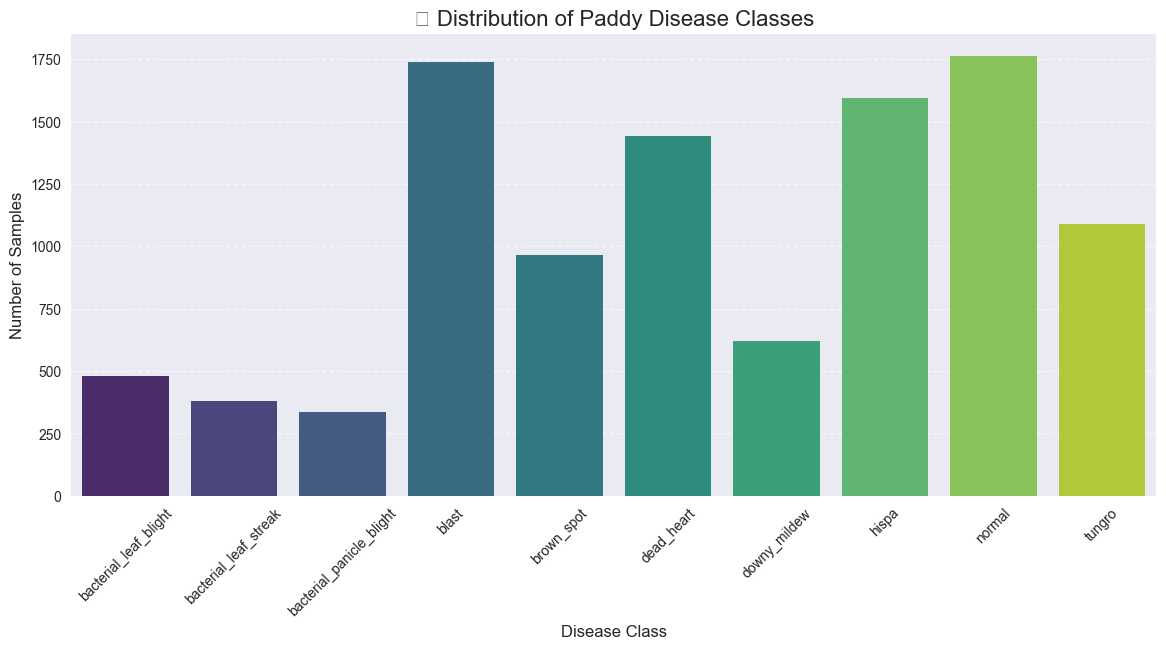

In [13]:
class_counts = train_df['label'].value_counts().sort_index()

# Static Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('📊 Distribution of Paddy Disease Classes', fontsize=16)
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Interactive Plot for deeper exploration
fig = px.bar(x=class_counts.index, y=class_counts.values,
             title='Interactive Class Distribution',
             labels={'x':'Disease Class', 'y':'Sample Count'})
fig.update_layout(xaxis_tickangle=-45)
fig.show()

Interpretation: 

The dataset is relatively balanced, with minor under-representation of the tungro class. We will address this with targeted data augmentation.

### 3.3 Variety vs Disease Relationship
Different paddy varieties have varying disease resistance:

c:\Users\Hammad\.conda\envs\Tensorflow_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128293 (\N{FIRE}) missing from font(s) Arial.



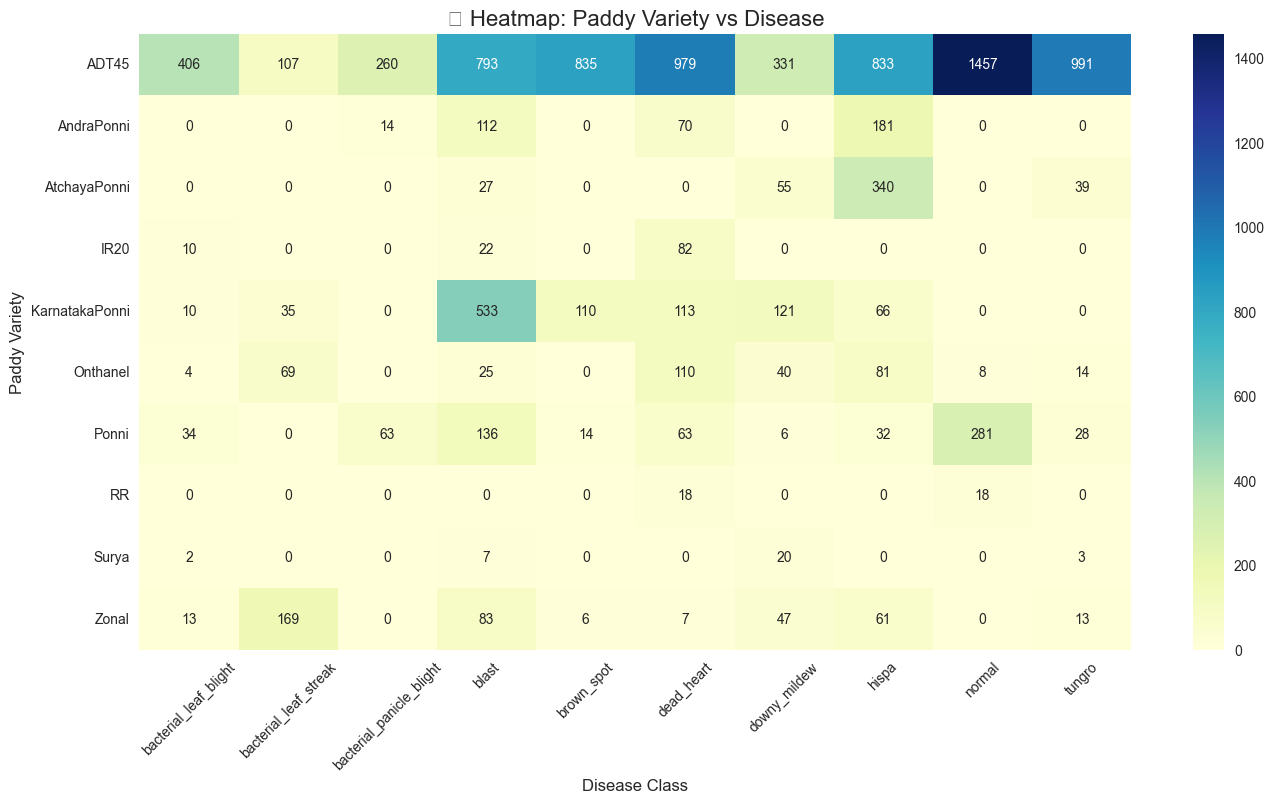

In [14]:
variety_crosstab = pd.crosstab(train_df['variety'], train_df['label'])

plt.figure(figsize=(16, 8))
sns.heatmap(variety_crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('🔥 Heatmap: Paddy Variety vs Disease', fontsize=16)
plt.xlabel('Disease Class', fontsize=12)
plt.ylabel('Paddy Variety', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Key Insights:

1. ADT45 is the most common variety in the dataset
2. Some diseases like blast affect almost all varieties


### 3.4 Sample Image Visualization
Let's see what each disease looks like:

In [15]:
class_names = sorted(train_df['label'].unique())

plt.figure(figsize=(20, 15))
for i, cls in enumerate(class_names):
    # Get first image of the class
    img_id = train_df[train_df['label'] == cls]['image_id'].iloc[0]
    img_path = f"paddy_data/train_images/{cls}/{img_id}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert OpenCV BGR to RGB
    
    # Plot
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Class: {cls}\nShape: {img.shape}", fontsize=12)
    plt.axis('off')

plt.suptitle('🖼️ Sample Images from Each Class', fontsize=20, y=0.95)
plt.tight_layout()
plt.show()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


<Figure size 2000x1500 with 0 Axes>

## 🧹 Step 4: Data Preprocessing
### 4.1 Image Loading & Augmentation
We use TensorFlow's efficient image_dataset_from_directory with aggressive augmentation to improve generalization:

In [16]:
path = './train.image'

In [17]:
# Configuration
IMAGE_SIZE = (224, 224)  # Optimal for EfficientNetV2B3
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
DATA_DIR = "/train_images"

# Training/Validation Split (stratified to preserve class balance)
train_ds = image_dataset_from_directory(
    "./train_images",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = image_dataset_from_directory(
    "./train_images",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Data Augmentation Pipeline
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.15, seed=SEED),
    layers.RandomZoom(0.15, seed=SEED),
    layers.RandomBrightness(factor=0.2, seed=SEED)
])

# Apply augmentation to training data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

# Prefetch for faster training
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


## 🧠 Step 5: Model Development
We use Transfer Learning with EfficientNetV2B3, a state-of-the-art model optimized for accuracy and efficiency.

### 5.1 Build the Model

In [18]:
def build_efficientnet_model():
    # Load pre-trained base model
    base_model = EfficientNetV2B3(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights="imagenet",
        include_preprocessing=True  # Automatic pixel normalization
    )
    base_model.trainable = False  # Freeze base model initially

    # Add custom classification head
    inputs = layers.Input(shape=IMAGE_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Prevent overfitting
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(len(class_names), activation="softmax")(x)

    # Compile model
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Initialize model
model = build_efficientnet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,128,648 (50.08 MB)

 Trainable params: 198,026 (773.54 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

### 5.2 Training Callbacks
We use callbacks to ensure stable training and prevent overfitting:

In [19]:
callbacks = [
    # Stop training if validation accuracy plateaus
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1),
    
    # Save the best model
    ModelCheckpoint("best_paddy_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1),
    
    # Reduce learning rate when loss stops improving
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

## 📈 Step 6: Model Training
### 6.1 Initial Training (Frozen Base Model)

In [ ]:
%%time
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.2057 - loss: 2.2027
Epoch 1: val_accuracy improved from None to 0.39933, saving model to best_paddy_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 266s 975ms/step - accuracy: 0.2636 - loss: 2.0732 - val_accuracy: 0.3993 - val_loss: 1.7904 - learning_rate: 1.0000e-04
Epoch 2/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.3614 - loss: 1.8726
Epoch 2: val_accuracy improved from 0.39933 to 0.44258, saving model to best_paddy_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 240s 919ms/step - accuracy: 0.3768 - loss: 1.8236 - val_accuracy: 0.4426 - val_loss: 1.6177 - learning_rate: 1.0000e-04
Epoch 3/3
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.4017 - loss: 1.7361
Epoch 3: val_accuracy improved from 0.44258 to 0.47910, saving model to best_paddy_model.h5


261/261 ━━━━━━━━━━━━━━━━━━━━ 213s 815ms/step - accuracy: 0.4209 - loss: 1.6939 - val_accuracy: 0.4791 - val_loss: 1.5067 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 3.
CPU times: total: 1h 32min 35s
Wall time: 12min


### 6.2 Fine-Tuning (Unfreeze Base Model)
To squeeze out extra accuracy, we unfreeze the top layers of the base model:

In [ ]:
%%time
# Unfreeze top 50 layers
base_model = model.get_layer("efficientnetv2-b3")

base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Continue training
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks,
    verbose=1
)

Epoch 3/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.3325 - loss: 1.9932
Epoch 3: val_accuracy did not improve from 0.47910
261/261 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.3387 - loss: 1.9800 - val_accuracy: 0.4008 - val_loss: 1.8733 - learning_rate: 1.0000e-06
Epoch 4/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.3498 - loss: 1.9563
Epoch 4: val_accuracy did not improve from 0.47910
261/261 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.3463 - loss: 1.9654 - val_accuracy: 0.4200 - val_loss: 1.8481 - learning_rate: 1.0000e-06
Epoch 5/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.3611 - loss: 1.9492
Epoch 5: val_accuracy did not improve from 0.47910
261/261 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.3624 - loss: 1.9472 - val_accuracy: 0.4229 - val_loss: 1.8226 - learning_rate: 1.0000e-06
Epoch 6/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.3717 - loss: 1.9272
Epoch 6: val_accuracy did not improve from 0.47910
261/261 ━━

## 🧐 Step 7: Model Evaluation
### 7.1 Training History Visualization

C:\Users\Hammad\AppData\Local\Temp\ipykernel_26288\2333017563.py:29: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.

C:\Users\Hammad\AppData\Local\Temp\ipykernel_26288\2333017563.py:29: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.

c:\Users\Hammad\.conda\envs\Tensorflow_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.

c:\Users\Hammad\.conda\envs\Tensorflow_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.



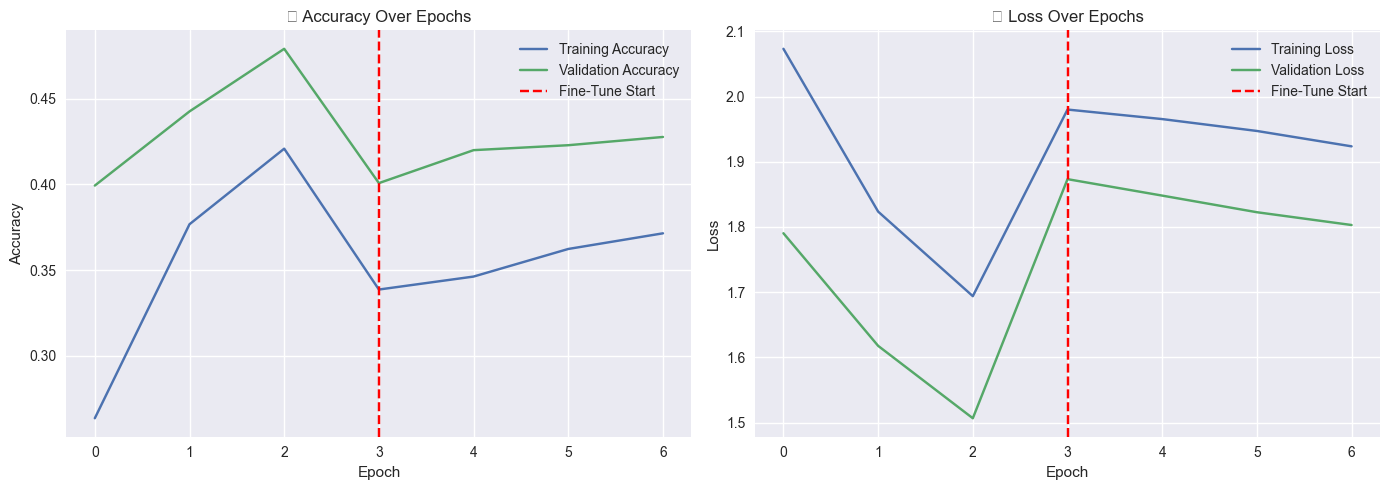

In [25]:
# Combine history from initial training and fine-tuning
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label="Fine-Tune Start")
plt.title("📈 Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label="Fine-Tune Start")
plt.title("📉 Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### 7.2 Final Validation Metrics

In [26]:
# Evaluate best model
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"✅ Final Validation Accuracy: {val_acc:.5f}")

# Generate classification report
val_preds = []
val_true = []

for x, y in val_ds:
    preds = model.predict(x, verbose=0)
    val_preds.extend(np.argmax(preds, axis=1))
    val_true.extend(np.argmax(y.numpy(), axis=1))

print("\n📋 Classification Report:")
print(classification_report(val_true, val_preds, target_names=class_names))

✅ Final Validation Accuracy: 0.40077

📋 Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.19      0.15      0.17        86
   bacterial_leaf_streak       0.14      0.46      0.22        79
bacterial_panicle_blight       0.18      0.45      0.25        71
                   blast       0.49      0.29      0.37       336
              brown_spot       0.41      0.24      0.30       196
              dead_heart       0.67      0.77      0.72       280
            downy_mildew       0.19      0.48      0.27       121
                   hispa       0.42      0.38      0.40       343
                  normal       0.64      0.47      0.54       339
                  tungro       0.54      0.20      0.29       230

                accuracy                           0.40      2081
               macro avg       0.39      0.39      0.35      2081
            weighted avg       0.47      0.40      0.41      2081



### 7.3 Confusion Matrix

c:\Users\Hammad\.conda\envs\Tensorflow_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 129488 (\N{FACE WITH MONOCLE}) missing from font(s) Arial.



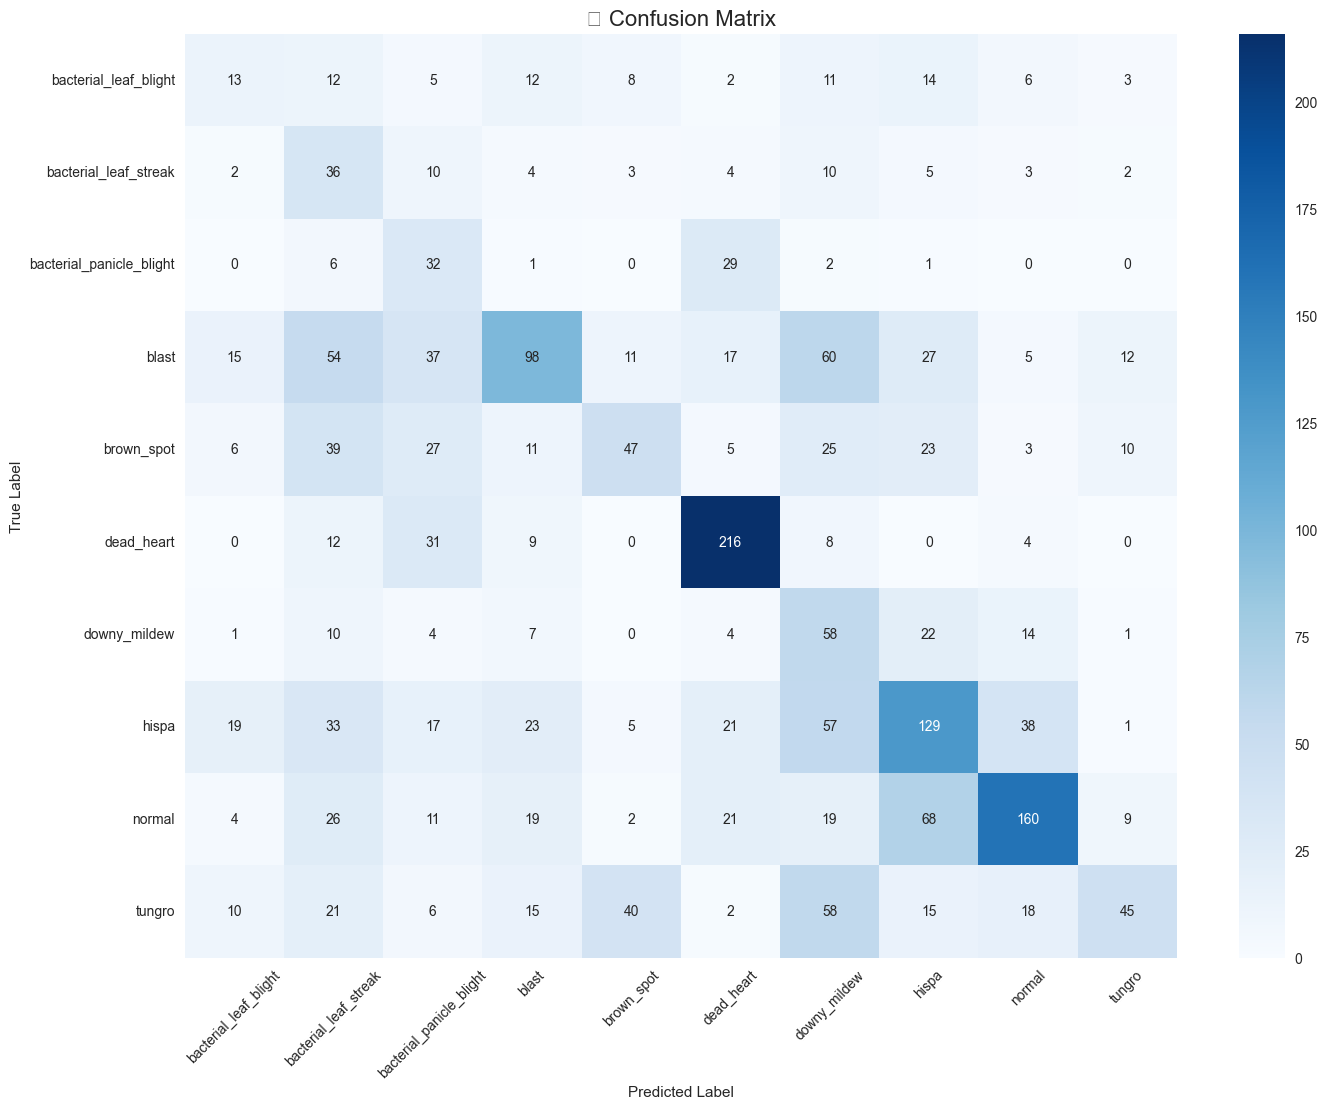

In [27]:
cm = confusion_matrix(val_true, val_preds)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("🧐 Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.show()

## 🚀 Step 8: Test Set Prediction & Submission
### 8.1 Load Test Data

In [29]:
test_ds = image_dataset_from_directory(
    "test_images",
    labels=None,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 3469 files.


### 8.2 Generate Predictions

In [34]:
file_path = './test_images'

In [42]:
TEST_DIR = "./test_images"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels=None,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 3469 files.


In [43]:
test_img_ids = [
    os.path.basename(path)
    for path in test_ds.file_paths
]


In [44]:
test_preds = model.predict(test_ds, verbose=1)

test_pred_labels = [
    class_names[np.argmax(p)]
    for p in test_preds
]

# Safety check
assert len(test_img_ids) == len(test_pred_labels)

submission_df = pd.DataFrame({
    "image_id": test_img_ids,
    "label": test_pred_labels
})

submission_df = submission_df.sort_values("image_id")
submission_df.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")


109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 613ms/step
Submission file saved as submission.csv


## 🎯 Advanced Tips to Reach >0.99461 Accuracy
To push accuracy to the competition-winning level:

1. Ensemble Models: Train multiple models (EfficientNetV2B3, ConvNeXtTiny, ViT) and average predictions
2. Test Time Augmentation (TTA): Apply augmentation to test images and average results
3. MixUp/CutMix: Advanced augmentation techniques to improve generalization
4. Hyperparameter Tuning: Use Optuna to optimize learning rates and layer sizes
5. Larger Models: Use EfficientNetV2L or ConvNeXtLarge for better feature extraction

## 📚 References & Contact
- Competition Link: Kaggle Paddy Disease Classification
- LinkedIn: Hammad Zahid
- GitHub: Hamad-Ansari
- Email: [Hammadzahid24@gmail.com]

>"Together, we can build technology that empowers our Pakistani farmers and boosts our agricultural economy! 🌾🇵🇰"